# Fast Food vs. Non Fast Food Restaurants

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import folium
from folium.plugins import MarkerCluster, HeatMap
import seaborn

In [2]:
seaborn.set()

In [3]:
# Load the data from the file
data_path = "./opening_hours.json"
data = pd.read_json(data_path, lines = True)

In [4]:
fast_food = data[data['amenity'] == 'fast_food']
non_fast_food = data[data['amenity'] != 'fast_food']

## Overview

### Heat Map of All Restaurants in Vancouver

In [5]:
coord_mid = [
    (data.lat.max() + data.lat.min()) / 2, 
    (data.lon.max() + data.lon.min()) / 2, 
]

In [6]:
heap_map_1 = folium.Map(
    location = coord_mid, 
    zoom_start = 10, 
)

In [7]:
HeatMap(
    list(zip(data['lat'].values, data['lon'].values)), 
    min_opacity = 0.2, 
    blur = 18
).add_to(heap_map_1)
heap_map_1

### Locations of Fast Food vs. Non Fast Food Restaurants

In [8]:
base_map = folium.Map(
    location = coord_mid, 
    zoom_start = 10
)

In [9]:
# Non fast food restaurants -- blue dots
non_fast_food.apply(
    lambda x: folium.CircleMarker(
        location = [x['lat'], x['lon']], 
        color = "#399cbd", 
        radius = 2, 
        tooltip = "Non Fast Food", 
        # opacity = 0.82
    ).add_to(base_map), 
    axis = 1
);

# Fast food restaurants -- red dots
fast_food.apply(
    lambda x: folium.CircleMarker(
        location = [x['lat'], x['lon']], 
        color = "#bd5a39", 
        radius = 2, 
        tooltip = "Fast Food", 
        # opacity = 0.82
    ).add_to(base_map), 
    axis = 1
);
base_map

## Comparison of Opening Hours

### Are Fast Food Restaurants Tend to Have Longer Opening Hours?

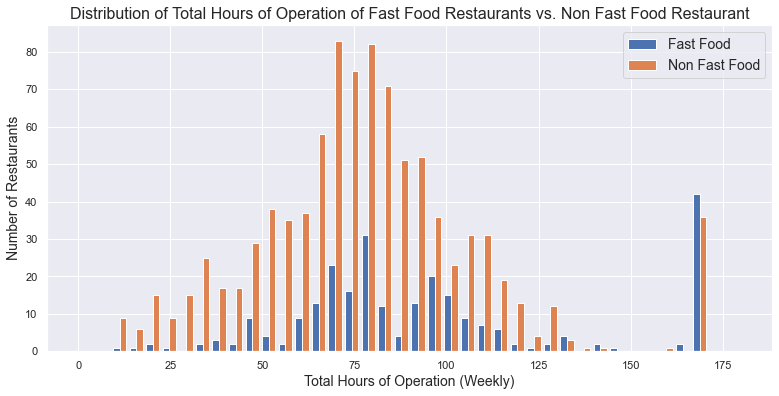

In [10]:
plt.figure(figsize = (13, 6))
plt.hist([
    fast_food['opening_hours_per_week'], 
    non_fast_food['opening_hours_per_week']], 
    np.linspace(0, 180, 41)
)
plt.title("Distribution of Total Hours of Operation of Fast Food Restaurants vs. Non Fast Food Restaurant", fontsize = 16)
plt.xlabel("Total Hours of Operation (Weekly)", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.legend(["Fast Food", "Non Fast Food"], fontsize = 14)
plt.show()

### Statistical Tests

By just looking at the graph, we don't see much difference. So, we are going to do some statistical tests to figure if there is actually a difference.

In [11]:
data_x, data_y = fast_food['opening_hours_per_week'], non_fast_food['opening_hours_per_week']

In [12]:
# Are they normally distributed
print("Fast food restaurants data normality test p-value:\t", stats.normaltest(data_x).pvalue)
print("Non fast food restaurants data normality test p-value:\t", stats.normaltest(data_y).pvalue)

Fast food restaurants data normality test p-value:	 0.000114151801545772
Non fast food restaurants data normality test p-value:	 1.4521520720518728e-20


In [13]:
# Do they have equal variance?
print("Equal-variance test p-value:", stats.levene(data_x, data_y).pvalue)

Equal-variance test p-value: 2.0127785864086503e-06


In [14]:
# Since we have enough data points, we may perform a T-test in this case, 
# even though they failed the normality test
# Perform a T-test
print("T-test p-value:", stats.ttest_ind(data_x, data_y, equal_var = False).pvalue)

T-test p-value: 7.672016423620156e-12


In [15]:
# p-value for U-test
print("U-test p-value", stats.mannwhitneyu(data_x, data_y).pvalue)

U-test p-value 5.0958822176561155e-11


## Restaurants that Open 24/7

In the previous step, we compared the opening hours of **fast food** restaurants and **non fast food** restaurants. However, we noticed that there are actually a lot of data points gathering in the right most bars in the histogram above. Those are the restaurants that open `24/7`. Would there be anything interesting if we take out those data points and take a deeper look?

### Distribution of Restaurants Open 24/7

In [16]:
fast_food_24_7 = fast_food[fast_food['opening_hours_per_week'] >= 168.0]
non_fast_food_24_7 = non_fast_food[non_fast_food['opening_hours_per_week'] >= 168.0]

In [17]:
base_map_24_7 = folium.Map(
    location = coord_mid, 
    zoom_start = 10, 
    tiles = "CartoDb dark_matter"
)

In [18]:
fast_food_24_7.apply(
    lambda x: folium.CircleMarker(
        location = [x['lat'], x['lon']], 
        color = "yellow", 
        radius = 1, 
        tooltip = "Fast Food"
    ).add_to(base_map_24_7), 
    axis = 1
);

In [19]:
non_fast_food_24_7.apply(
    lambda x: folium.CircleMarker(
        location = [x['lat'], x['lon']], 
        color = "white", 
        radius = 1, 
        tooltip = "Non Fast Food"
    ).add_to(base_map_24_7), 
    axis = 1
);
base_map_24_7

### Can the Type of A Restaurant Affect its Opening Hours?

In [20]:
contingency = [
    [len(fast_food_24_7), len(fast_food) - len(fast_food_24_7)], 
    [len(non_fast_food_24_7), len(non_fast_food) - len(non_fast_food_24_7)]
]

In [21]:
contingency_df = pd.DataFrame(
    data = contingency, 
    columns = ["24/7", "Not 24/7"], 
    index = ["Fast Food", "Non Fast Food"]
)
contingency_df

,24/7,Not 24/7
Fast Food,42,219
Non Fast Food,36,899


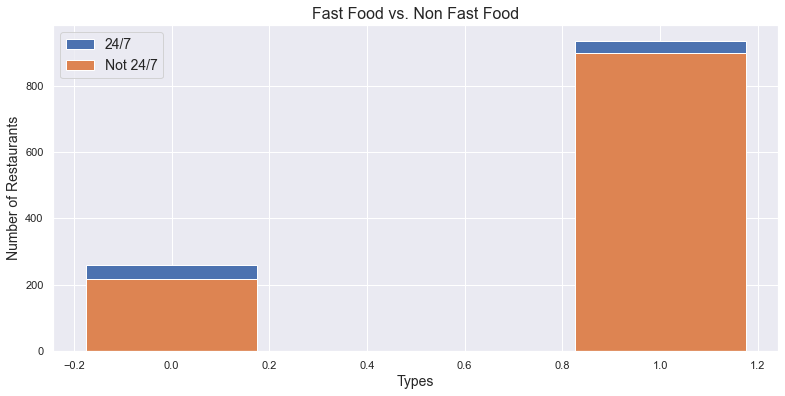

In [22]:
categories = ["Fast Food", "Non Fast Food"]
plt.figure(figsize = (13, 6))
plt.bar(
    np.arange(2), 
    contingency_df["24/7"], 
    width = 0.35, 
    bottom = contingency_df["Not 24/7"]
)
plt.bar(
    np.arange(2), 
    contingency_df["Not 24/7"], 
    width = 0.35
)

plt.title("Fast Food vs. Non Fast Food", fontsize = 16)
plt.xlabel("Types", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.legend(["24/7", "Not 24/7"], fontsize = 14)
plt.show()

In [23]:
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print("Chi-Square test p-value:", p)

Chi-Square test p-value: 3.9105474632848085e-12
